# AI Alpha Research

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

Looking in links: https://files.pythonhosted.org/


In [2]:
import helper

import cvxpy as cvx
import numpy as np
import pandas as pd
import time

from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Data Bundle

In [3]:
import os
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'data', 'zipline')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], helper.EOD_BUNDLE_NAME)
bundles.register(helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


### Universe
Since the liquidity matters, choose top 500 stocks in terms of average dollar volume traded among highly developed market - US Equity.
Bid-ask spead for these equities are 2-5bp, as oppose to 20-30bp for less liquid stocks. To target 400bp annual return from daily trading, more than 10bp for a single trade is not acceptable.

In [4]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(helper.EOD_BUNDLE_NAME)
engine = helper.build_pipeline_engine(bundle_data, trading_calendar)

In [5]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

## Get Returns

In [6]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

In [37]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [38]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5, days=1),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-06 00:00:00+00:00,0.019564,0.012632,-0.032896,-0.000801,0.000000,0.011617,-0.002103,0.003721,0.001552,0.005591,...,-0.000420,0.016856,0.006423,-0.005688,0.000000,0.000000,0.007006,-0.030947,-0.002809,0.000000
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000


# Statistical Risk Model

## PCA

In [9]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca


In [10]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[-0.04316847, -0.05874471, -0.03433256, ..., -0.03843904,
        -0.06092493, -0.01367163],
       [ 0.01955111,  0.19637679,  0.03451503, ...,  0.01749339,
        -0.01044197,  0.01892192],
       [-0.00993375,  0.07868756,  0.01133839, ..., -0.0157519 ,
         0.01261759,  0.01867875],
       ...,
       [-0.01174265,  0.01398085,  0.05143999, ...,  0.04125323,
         0.0035229 ,  0.03682367],
       [ 0.00526925, -0.04680674,  0.05716915, ...,  0.00671842,
        -0.02193923,  0.00833979],
       [-0.00535269, -0.01599057,  0.08414961, ..., -0.01540844,
         0.02188794,  0.01500221]])

In [11]:
pca.components_.shape

(20, 490)

<Container object of 20 artists>

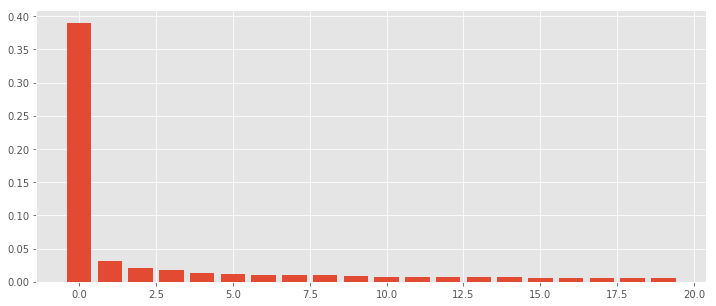

In [12]:
plt.figure(figsize=(12,5))
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

## Factor Betas

In [13]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """Get the factor betas from the PCA model."""
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    factor_betas = pd.DataFrame(pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)
    
    return factor_betas


In [14]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.043168,0.019551,-0.009934,0.010540,-0.018198,0.010745,0.001129,0.039739,-0.013805,0.012737,-0.023840,-0.001417,0.020993,0.034610,-0.030489,0.033606,-0.011429,-0.011743,0.005269,-0.005353
Equity(1 [AAL]),-0.058745,0.196377,0.078688,0.082096,0.348478,-0.138082,0.071293,0.105248,-0.045890,-0.085478,0.003283,0.105343,0.067216,-0.044060,-0.022316,0.017263,-0.033108,0.013981,-0.046807,-0.015991
Equity(2 [AAP]),-0.034333,0.034515,0.011338,-0.025437,-0.008172,-0.013183,-0.060952,0.006549,-0.032654,-0.013515,0.028967,0.038365,-0.049605,-0.005246,-0.021970,0.029767,-0.011636,0.051440,0.057169,0.084150
Equity(3 [AAPL]),-0.034100,-0.001393,0.039467,-0.017213,-0.030470,-0.017571,0.023251,0.011430,-0.026568,-0.007719,0.026863,0.007319,0.004818,0.012886,0.052565,-0.073445,-0.031792,0.090794,-0.011189,0.042914
Equity(4 [ABBV]),-0.018031,0.025682,0.004352,-0.070782,0.013199,0.054277,-0.015678,0.040462,-0.012455,-0.035151,-0.051324,-0.040416,-0.051203,-0.018582,-0.011269,-0.042007,0.015886,0.045986,0.015993,0.065880
Equity(5 [ABC]),-0.028900,0.032592,-0.007421,-0.033552,-0.011521,0.026484,0.010850,-0.005704,0.013548,-0.029679,-0.031618,0.017152,-0.003050,0.026356,0.007879,0.008331,-0.018346,-0.013914,0.010620,-0.027396
Equity(6 [ABT]),-0.029057,0.029778,-0.029709,-0.035743,-0.011574,0.060201,-0.020040,0.040985,-0.018040,-0.006208,-0.031578,-0.023080,-0.014368,-0.000543,-0.019329,0.014288,-0.039381,0.010712,0.017120,0.002107
Equity(7 [ACN]),-0.043377,0.002569,0.004132,-0.003493,-0.054307,0.005374,0.002780,0.030432,-0.018802,-0.001783,-0.035404,-0.010932,0.026112,-0.012331,0.003221,0.017700,-0.002851,-0.012359,-0.014009,-0.038557
Equity(8 [ADBE]),-0.047303,0.026612,0.030571,-0.021147,-0.048388,-0.007087,0.007434,0.007471,0.014871,-0.001534,-0.012384,-0.006674,0.035007,-0.043366,0.010603,-0.006379,0.021273,-0.036388,0.001268,-0.048446
Equity(9 [ADI]),-0.047123,-0.003812,0.056008,-0.015538,-0.069462,-0.005604,0.100704,0.063077,0.001608,0.019130,0.011017,0.003487,-0.054657,-0.042238,-0.000143,-0.048432,0.003743,0.045833,0.014835,0.007686


## Factor Returns

In [15]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """Get the factor returns from the PCA model."""
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    factor_returns = pd.DataFrame(pca.transform(returns), index=factor_return_indices, columns=factor_return_columns)
    
    return factor_returns

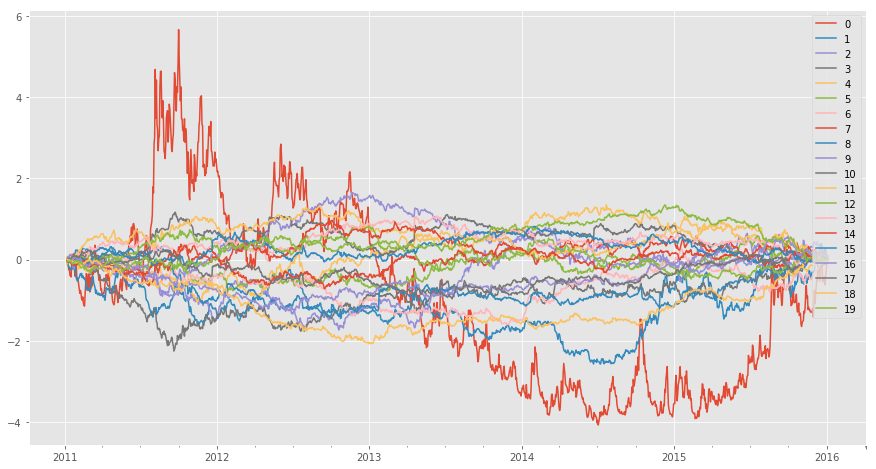

In [16]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=True, figsize=(15,8))

## Factor Covariance Matrix

In [17]:
def factor_cov_matrix(factor_returns, ann_factor):
    factor_cov_matrix = np.diag(np.var(factor_returns, axis=0, ddof=1)*ann_factor)
    
    return factor_cov_matrix


In [18]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[14.01830425,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.10591127,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.77099145,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.61798821,  0.        ,
         0.        ,  0.        ,  0.        ,  

## Idiosyncratic Variance Matrix

In [19]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    _common_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    _residuals = (returns - _common_returns)
    idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(_residuals)*ann_factor), returns.columns, returns.columns)
    
    return idiosyncratic_var_matrix


In [20]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.022725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(1 [AAL]),0.000000,0.051901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(2 [AAP]),0.000000,0.000000,0.054312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(3 [AAPL]),0.000000,0.000000,0.000000,0.048019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(4 [ABBV]),0.000000,0.000000,0.000000,0.000000,0.030404,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(5 [ABC]),0.000000,0.000000,0.000000,0.000000,0.000000,0.018545,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(6 [ABT]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014815,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(7 [ACN]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021775,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(8 [ADBE]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034421,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
Equity(9 [ADI]),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018984,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


## Idiosyncratic Variance Vector

In [21]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    idiosyncratic_var_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix), returns.columns)
    
    return idiosyncratic_var_vector

In [22]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(0 [A]),0.022725
Equity(1 [AAL]),0.051901
Equity(2 [AAP]),0.054312
Equity(3 [AAPL]),0.048019
Equity(4 [ABBV]),0.030404
Equity(5 [ABC]),0.018545
Equity(6 [ABT]),0.014815
Equity(7 [ACN]),0.021775
Equity(8 [ADBE]),0.034421
Equity(9 [ADI]),0.018984


## Predict Portfolio Risk
Calculate the portfolio risk as the square root of the portfolio variance: $ \sqrt{X^{T}(BFB^{T} + S)X} $ 

where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [23]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    predicted_portfolio_risk = np.sqrt(weights.T.dot(factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix).dot(weights))
    
    return predicted_portfolio_risk[0][0]

In [24]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.16094824687040468

# Alpha Factors
Create the following three factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Smoothed Factor -  [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [54]:
# Use 4 years data as Momentum 1 Year Factor is not available during the first year
factor_start_date = universe_end_date - pd.DateOffset(years=4, days=-1)
print(factor_start_date)
print(universe_end_date)

2012-01-06 00:00:00+00:00
2016-01-05 00:00:00+00:00


In [55]:
from zipline.pipeline.factors import CustomFactor, DailyReturns, Returns, SimpleMovingAverage, AnnualizedVolatility
from zipline.pipeline.data import USEquityPricing

sector = helper.Sector()

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor
    """
    unsmoothed_factor = -Returns(window_length=5, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length) \
        .rank() \
        .zscore()

class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]
        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    unsmoothed_factor = TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

In [56]:
# Add alpha factors to the pipeline
pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(20, universe, sector),
    'Mean_Reversion_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment_smoothed(2, 10, universe),
    'Overnight_Sentiment_Smoothed')

In [57]:
# Check factors
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_Sector_Neutral_Smoothed  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                                    -0.055753   
                          Equity(1 [AAL])                                   0.137524   
                          Equity(2 [AAP])                                  -0.167259   
                          Equity(3 [AAPL])                                 -1.706037   
                          Equity(5 [ABC])                                   0.263897   
                          Equity(6 [ABT])                                  -0.412571   
                          Equity(7 [ACN])                                   1.148508   
                          Equity(8 [ADBE])                                 -1.126207   
                          Equity(9 [ADI])                                  -0.784257   
                          Equity(10 [ADM])                                  1.230279   
                          Equity(11 [ADP])                                 -1.386387   
                          Equity(12 [ADS])                                  0.970099   
                          Equity(13 [ADSK])                                 1.624266   
                          Equity(14 [AEE])                                  0.249029   
                          Equity(15 [AEP])                                 -0.323366   
                          Equity(16 [AES])                                  1.178243   
                          Equity(17 [AET])                                 -0.494342   
                          Equity(18 [AFL])                                  0.018584   
                          Equity(19 [AGN])                                  1.594531   
                          Equity(20 [AIG])                                  0.122656   
                          Equity(21 [AIV])                                 -0.130090   
                          Equity(22 [AIZ])                                 -0.903196   
                          Equity(23 [AJG])                                 -1.044436   
                          Equity(24 [AKAM])                                -1.230279   
                          Equity(25 [ALB])                                  0.717353   
                          Equity(26 [ALGN])                                 1.051870   
                          Equity(27 [ALK])                                  0.509209   
                          Equity(28 [ALL])                                 -0.092921   
                          Equity(30 [ALXN])                                -0.888329   
                          Equity(31 [AMAT])                                -0.308499   
...                                                                              ...   
2016-01-05 00:00:00+00:00 Equity(460 [VRSN])                                1.322206   
                          Equity(461 [VRTX])                                0.196014   
                          Equity(462 [VTR])                                -1.578807   
                          Equity(463 [VZ])                                 -0.559532   
                          Equity(464 [WAT])                                -0.659321   
                          Equity(465 [WBA])                                -0.003564   
                          Equity(466 [WDC])                                 0.039203   
                          Equity(467 [WEC])                                -0.987200   
                          Equity(468 [WFC])                                -0.630810   
                          Equity(469 [WHR])                                 1.115500   
                          Equity(471 [WM])                                 -1.136883   
                          Equity(472 [WMB])                                 0.887411   
                          Equity(473 [WMT])                                -1.393484   
                          Equity(474 [WRK])                                 0.901666  

# Add AI Alpha Factor
## Features
### Universal Quant Features
Features to capture the universe
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

In [58]:
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')
pipeline.add(sector, 'sector_code')

### Regime Features
Features to capture market-wide regimes.
- High and low volatility 20d, 120d
- High and low dispersion 20d, 120d

In [59]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))


pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')

In [60]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))


pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

### Target
Predict go forward 1-week return. Create the trailing 5-day return as a quantized target factor.

In [61]:
pipeline.add(Returns(window_length=5, mask=universe).quantiles(2), 'return_5d')
pipeline.add(Returns(window_length=5, mask=universe).quantiles(25), 'return_5d_p')

### Date Features
Make columns for the trees to split on that might capture trader/investor behavior due to calendar anomalies.

In [62]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors['is_Janaury'] = all_factors.index.get_level_values(0).month == 1
all_factors['is_December'] = all_factors.index.get_level_values(0).month == 12
all_factors['weekday'] = all_factors.index.get_level_values(0).weekday
all_factors['quarter'] = all_factors.index.get_level_values(0).quarter
all_factors['qtr_yr'] = all_factors.quarter.astype('str') + '_' + all_factors.index.get_level_values(0).year.astype('str')
all_factors['month_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BM'))
all_factors['month_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BMS'))
all_factors['qtr_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQ'))
all_factors['qtr_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQS'))

print("all_factors: ", all_factors.shape)
all_factors.head()


all_factors:  (480134, 23)


Mean_Reversion_Sector_Neutral_Smoothed  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                                  -0.055753   
                          Equity(1 [AAL])                                 0.137524   
                          Equity(2 [AAP])                                -0.167259   
                          Equity(3 [AAPL])                               -1.706037   
                          Equity(5 [ABC])                                 0.263897   

                                            Momentum_1YR  \
2012-01-06 00:00:00+00:00 Equity(0 [A])        -0.083381   
                          Equity(1 [AAL])      -1.705525   
                          Equity(2 [AAP])       0.704950   
                          Equity(3 [AAPL])      1.432641   
                          Equity(5 [ABC])       0.045481   

                                            Overnight_Sentiment_Smoothed  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                         0.573651   
                          Equity(1 [AAL])                       1.121394   
                          Equity(2 [AAP])                       1.439678   
                          Equity(3 [AAPL])                     -0.558847   
                          Equity(5 [ABC])                      -0.099926   

                                            adv_120d   adv_20d  \
2012-01-06 00:00:00+00:00 Equity(0 [A])     1.380462  1.417472   
                          Equity(1 [AAL])   0.048113  0.418210   
                          Equity(2 [AAP])  -0.810513 -0.714288   
                          Equity(3 [AAPL])  1.728354  1.728354   
                          Equity(5 [ABC])  -0.018505 -0.129534   

                                            dispersion_120d  dispersion_20d  \
2012-01-06 00:00:00+00:00 Equity(0 [A])            0.017162        0.014459   
                          Equity(1 [AAL])          0.017162        0.014459   
                          Equity(2 [AAP])          0.017162        0.014459   
                          Equity(3 [AAPL])         0.017162        0.014459   
                          Equity(5 [ABC])          0.017162        0.014459   

                                            market_vol_120d  market_vol_20d  \
2012-01-06 00:00:00+00:00 Equity(0 [A])            0.351987        0.215591   
                          Equity(1 [AAL])          0.351987        0.215591   
                          Equity(2 [AAP])          0.351987        0.215591   
                          Equity(3 [AAPL])         0.351987        0.215591   
                          Equity(5 [ABC])          0.351987        0.215591   

                                            return_5d    ...      \
2012-01-06 00:00:00+00:00 Equity(0 [A])             0    ...       
                          Equity(1 [AAL])           1    ...       
                          Equity(2 [AAP])           1    ...       
                          Equity(3 [AAPL])          1    ...       
                          Equity(5 [ABC])           1    ...       

                                            volatility_20d  is_Janaury  \
2012-01-06 00:00:00+00:00 Equity(0 [A])          -0.884532        True   
                          Equity(1 [AAL])         1.713550        True   
                          Equity(2 [AAP])        -0.869728        True   
                          Equity(3 [AAPL])       -1.313845        True   
                          Equity(5 [ABC])        -1.128796        True   

                                            is_December  weekday  quarter  \
2012-01-06 00:00:00+00:00 Equity(0 [A])           False        4        1   
                          Equity(1 [AAL])         False        4        1   
                          Equity(2 [AAP])         False        4        1   
                          Equity(3 [AAPL])        False        4        1   
                          Equity(5 [ABC])         False        4        1   

                                            q

### One Hot Encode Sectors
For the model to better understand the sector data

In [63]:
all_factors['sector_code'].head()

2012-01-06 00:00:00+00:00  Equity(0 [A])       0
                           Equity(1 [AAL])     3
                           Equity(2 [AAP])     8
                           Equity(3 [AAPL])    1
                           Equity(5 [ABC])     0
Name: sector_code, dtype: int64

In [64]:
sector_lookup = pd.read_csv('./data/sector/labels.csv', index_col='Sector_i')['Sector'].to_dict()
sector_lookup

{0: 'Healthcare',
 1: 'Technology',
 2: 'Consumer Defensive',
 3: 'Industrials',
 4: 'Utilities',
 5: 'Financial Services',
 6: 'Real Estate',
 7: 'Communication Services',
 8: 'Consumer Cyclical',
 9: 'Energy',
 10: 'Basic Materials'}

In [65]:
sector_columns = []
for sector_i, sector_name in sector_lookup.items():
    secotr_column = 'sector_{}'.format(sector_name)
    sector_columns.append(secotr_column)
    all_factors[secotr_column] = (all_factors['sector_code'] == sector_i)

all_factors[sector_columns].head()

sector_Healthcare  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                  True   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(5 [ABC])                True   

                                            sector_Technology  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])               True   
                          Equity(5 [ABC])               False   

                                            sector_Consumer Defensive  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                         False   
                          Equity(1 [AAL])                       False   
                          Equity(2 [AAP])                       False   
                          Equity(3 [AAPL])                      False   
                          Equity(5 [ABC])                       False   

                                            sector_Industrials  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                  False   
                          Equity(1 [AAL])                 True   
                          Equity(2 [AAP])                False   
                          Equity(3 [AAPL])               False   
                          Equity(5 [ABC])                False   

                                            sector_Utilities  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])             False   
                          Equity(5 [ABC])              False   

                                            sector_Financial Services  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                         False   
                          Equity(1 [AAL])                       False   
                          Equity(2 [AAP])                       False   
                          Equity(3 [AAPL])                      False   
                          Equity(5 [ABC])                       False   

                                            sector_Real Estate  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                  False   
                          Equity(1 [AAL])                False   
                          Equity(2 [AAP])                False   
                          Equity(3 [AAPL])               False   
                          Equity(5 [ABC])                False   

                                            sector_Communication Services  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                             False   
                          Equity(1 [AAL])                           False   
                          Equity(2 [AAP])                           False   
                          Equity(3 [AAPL])                          False   
                          Equity(5 [ABC])                           False   

                                            sector_Consumer Cyclical  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                       True   
                          Equity(3 [AAPL])                     False   
                          Equity(5 [ABC])                      False   

                                            sector_Energy  \
2012-01-06 00:00:00+00:00 Equity(0 [A])             False   
                          Equity(1 [AAL])           False   
                          Equity(2 [AAP])           False   
                          Equity(3 [AAPL])          False   
    

### Shift Target
Shifted 5 day returns for training the model

In [66]:
all_factors['target'] = all_factors.groupby(level=1)['return_5d'].shift(-5)
all_factors[['return_5d','target']].reset_index().sort_values(['level_1', 'level_0']).head(10)

,level_0,level_1,return_5d,target
0,2012-01-06 00:00:00+00:00,Equity(0 [A]),0,0.0
468,2012-01-09 00:00:00+00:00,Equity(0 [A]),0,0.0
936,2012-01-10 00:00:00+00:00,Equity(0 [A]),0,0.0
1404,2012-01-11 00:00:00+00:00,Equity(0 [A]),0,0.0
1872,2012-01-12 00:00:00+00:00,Equity(0 [A]),0,0.0
2340,2012-01-13 00:00:00+00:00,Equity(0 [A]),0,0.0
2808,2012-01-17 00:00:00+00:00,Equity(0 [A]),0,0.0
3276,2012-01-18 00:00:00+00:00,Equity(0 [A]),0,0.0
3744,2012-01-19 00:00:00+00:00,Equity(0 [A]),0,0.0
4212,2012-01-20 00:00:00+00:00,Equity(0 [A]),0,0.0


### IID Check of Target
Becasuse of the overlapping problem for the shifted 5 days return, the returns might not be correlated.
Check if the returns are independent and identically distributed.

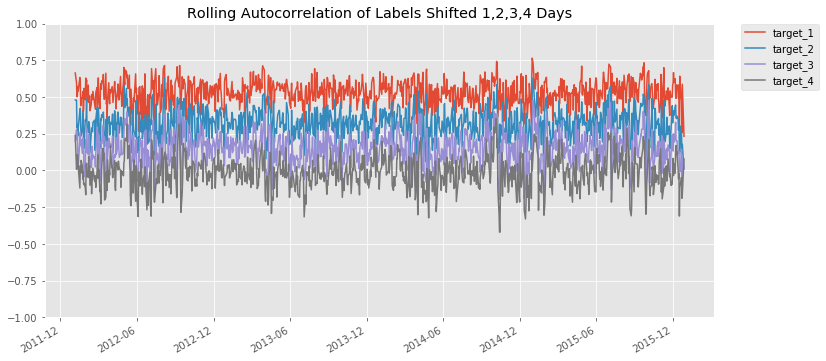

In [67]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]

all_factors['target_p'] = all_factors.groupby(level=1)['return_5d_p'].shift(-5)
all_factors['target_1'] = all_factors.groupby(level=1)['return_5d'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level=1)['return_5d'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level=1)['return_5d'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level=1)['return_5d'].shift(-1)

g = all_factors.dropna().groupby(level=0)

plt.figure(figsize=(12,6))
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
    
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

### Train/Valid/Test Splits
When splitting, make sure the data is in order from train, validation, and test respectivly. Say `train_size` is 0.7, `valid_size` is 0.2, and `test_size` is 0.1. The first 70 percent of `all_x` and `all_y` would be the train set. The next 20 percent of `all_x` and `all_y` would be the validation set. The last 10 percent of `all_x` and `all_y` would be the test set. Make sure not split a day between multiple datasets. It should be contained within a single dataset.

In [102]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size >= 0.9999
    assert train_size + valid_size + test_size <= 1.0001
    
    train_size_loc = int(all_x.shape[0]*train_size)
    valid_size_loc = int(all_x.shape[0]*valid_size) + train_size_loc
    
    x_train = all_x[:train_size_loc]
    x_valid = all_x[train_size_loc:valid_size_loc]
    x_test = all_x[valid_size_loc:]
    y_train = all_y[:train_size_loc]
    y_valid = all_y[train_size_loc:valid_size_loc]
    y_test = all_y[valid_size_loc:]
        
    return x_train, x_valid, x_test, y_train, y_valid, y_test


In [103]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_Janaury', 'is_December', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.7, 0.2, 0.1)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                                  -0.055753   
                          Equity(1 [AAL])                                 0.137524   
                          Equity(2 [AAP])                                -0.167259   
                          Equity(3 [AAPL])                               -1.706037   
                          Equity(5 [ABC])                                 0.263897   

                                            Momentum_1YR  \
2012-01-06 00:00:00+00:00 Equity(0 [A])        -0.083381   
                          Equity(1 [AAL])      -1.705525   
                          Equity(2 [AAP])       0.704950   
                          Equity(3 [AAPL])      1.432641   
                          Equity(5 [ABC])       0.045481   

                                            Overnight_Sentiment_Smoothed  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                         0.573651   
                          Equity(1 [AAL])                       1.121394   
                          Equity(2 [AAP])                       1.439678   
                          Equity(3 [AAPL])                     -0.558847   
                          Equity(5 [ABC])                      -0.099926   

                                            adv_120d   adv_20d  \
2012-01-06 00:00:00+00:00 Equity(0 [A])     1.380462  1.417472   
                          Equity(1 [AAL])   0.048113  0.418210   
                          Equity(2 [AAP])  -0.810513 -0.714288   
                          Equity(3 [AAPL])  1.728354  1.728354   
                          Equity(5 [ABC])  -0.018505 -0.129534   

                                            dispersion_120d  dispersion_20d  \
2012-01-06 00:00:00+00:00 Equity(0 [A])            0.017162        0.014459   
                          Equity(1 [AAL])          0.017162        0.014459   
                          Equity(2 [AAP])          0.017162        0.014459   
                          Equity(3 [AAPL])         0.017162        0.014459   
                          Equity(5 [ABC])          0.017162        0.014459   

                                            market_vol_120d  market_vol_20d  \
2012-01-06 00:00:00+00:00 Equity(0 [A])            0.351987        0.215591   
                          Equity(1 [AAL])          0.351987        0.215591   
                          Equity(2 [AAP])          0.351987        0.215591   
                          Equity(3 [AAPL])         0.351987        0.215591   
                          Equity(5 [ABC])          0.351987        0.215591   

                                            volatility_20d  \
2012-01-06 00:00:00+00:00 Equity(0 [A])          -0.884532   
                          Equity(1 [AAL])         1.713550   
                          Equity(2 [AAP])        -0.869728   
                          Equity(3 [AAPL])       -1.313845   
                          Equity(5 [ABC])        -1.128796   

                                                     ...            \
2012-01-06 00:00:00+00:00 Equity(0 [A])              ...             
                          Equity(1 [AAL])            ...             
                          Equity(2 [AAP])            ...             
                          Equity(3 [AAPL])           ...             
                          Equity(5 [ABC])            ...             

                                            sector_Technology  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])               True   
                          Equity(5 [ABC])               False   

                                            sector_Consumer Defensive  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                         False   
                          Equit

In [166]:
X_test.tail()

Mean_Reversion_Sector_Neutral_Smoothed  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])                                -0.324315   
                          Equity(487 [YUM])                                -1.400612   
                          Equity(488 [ZBH])                                 0.338570   
                          Equity(489 [ZION])                                1.165395   
                          Equity(490 [ZTS])                                -0.224526   

                                              Momentum_1YR  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])      -0.137407   
                          Equity(487 [YUM])       0.166335   
                          Equity(488 [ZBH])      -1.070330   
                          Equity(489 [ZION])     -0.159103   
                          Equity(490 [ZTS])       0.115711   

                                              Overnight_Sentiment_Smoothed  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])                      -1.389178   
                          Equity(487 [YUM])                       0.017674   
                          Equity(488 [ZBH])                       0.151997   
                          Equity(489 [ZION])                      0.809470   
                          Equity(490 [ZTS])                      -0.455990   

                                              adv_120d   adv_20d  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])  -1.537640 -1.622475   
                          Equity(487 [YUM])   0.837749  0.554964   
                          Equity(488 [ZBH])  -0.159066 -0.314598   
                          Equity(489 [ZION]) -0.965002 -0.724635   
                          Equity(490 [ZTS])   0.229762 -0.180275   

                                              dispersion_120d  dispersion_20d  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])          0.014916        0.014731   
                          Equity(487 [YUM])          0.014916        0.014731   
                          Equity(488 [ZBH])          0.014916        0.014731   
                          Equity(489 [ZION])         0.014916        0.014731   
                          Equity(490 [ZTS])          0.014916        0.014731   

                                              market_vol_120d  market_vol_20d  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])          0.186573        0.184337   
                          Equity(487 [YUM])          0.186573        0.184337   
                          Equity(488 [ZBH])          0.186573        0.184337   
                          Equity(489 [ZION])         0.186573        0.184337   
                          Equity(490 [ZTS])          0.186573        0.184337   

                                              volatility_20d  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])        -0.300458   
                          Equity(487 [YUM])         0.484268   
                          Equity(488 [ZBH])        -1.276065   
                          Equity(489 [ZION])        1.099324   
                          Equity(490 [ZTS])        -0.858958   

                                                       ...            \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])            ...             
                          Equity(487 [YUM])            ...             
                          Equity(488 [ZBH])            ...             
                          Equity(489 [ZION])           ...             
                          Equity(490 [ZTS])            ...             

                                              sector_Technology  \
2015-12-28 00:00:00+00:00 Equity(486 [XYL])               False   
                          Equity(487 [YUM])               False   
                          Equity(488 [ZBH])               False   
                          Equity(489 [ZION])              False   
                          Equity(490 [ZTS])               False   

                                              sector_Consumer Defensive

In [167]:
all_factors.tail()

Mean_Reversion_Sector_Neutral_Smoothed  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])                                -0.267292   
                          Equity(487 [YUM])                                -0.516765   
                          Equity(488 [ZBH])                                 0.060586   
                          Equity(489 [ZION])                                1.421995   
                          Equity(490 [ZTS])                                -0.801877   

                                              Momentum_1YR  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])       0.342802   
                          Equity(487 [YUM])       0.212898   
                          Equity(488 [ZBH])      -1.136661   
                          Equity(489 [ZION])     -0.133513   
                          Equity(490 [ZTS])       0.313935   

                                              Overnight_Sentiment_Smoothed  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])                      -0.689287   
                          Equity(487 [YUM])                      -1.445735   
                          Equity(488 [ZBH])                      -1.438666   
                          Equity(489 [ZION])                      0.816540   
                          Equity(490 [ZTS])                      -0.045952   

                                              adv_120d   adv_20d  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])  -1.565919 -1.615406   
                          Equity(487 [YUM])   0.830679  0.540825   
                          Equity(488 [ZBH])  -0.166136 -0.583243   
                          Equity(489 [ZION]) -0.993280 -0.682217   
                          Equity(490 [ZTS])   0.194414 -0.166136   

                                              dispersion_120d  dispersion_20d  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])          0.014908        0.014232   
                          Equity(487 [YUM])          0.014908        0.014232   
                          Equity(488 [ZBH])          0.014908        0.014232   
                          Equity(489 [ZION])         0.014908        0.014232   
                          Equity(490 [ZTS])          0.014908        0.014232   

                                              market_vol_120d  market_vol_20d  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])          0.185574        0.179557   
                          Equity(487 [YUM])          0.185574        0.179557   
                          Equity(488 [ZBH])          0.185574        0.179557   
                          Equity(489 [ZION])         0.185574        0.179557   
                          Equity(490 [ZTS])          0.185574        0.179557   

                                              return_5d    ...     \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])           0    ...      
                          Equity(487 [YUM])           0    ...      
                          Equity(488 [ZBH])           1    ...      
                          Equity(489 [ZION])          0    ...      
                          Equity(490 [ZTS])           1    ...      

                                              sector_Communication Services  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])                           False   
                          Equity(487 [YUM])                           False   
                          Equity(488 [ZBH])                           False   
                          Equity(489 [ZION])                          False   
                          Equity(490 [ZTS])                           False   

                                              sector_Consumer Cyclical  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])                      False   
                          Equity(487 [YUM])                       True   
                          Equity(488 [ZBH])                      False   
                          Equity(489 [ZION])                     False   
                          Equity

## Random Forests
### Visualize a Tree

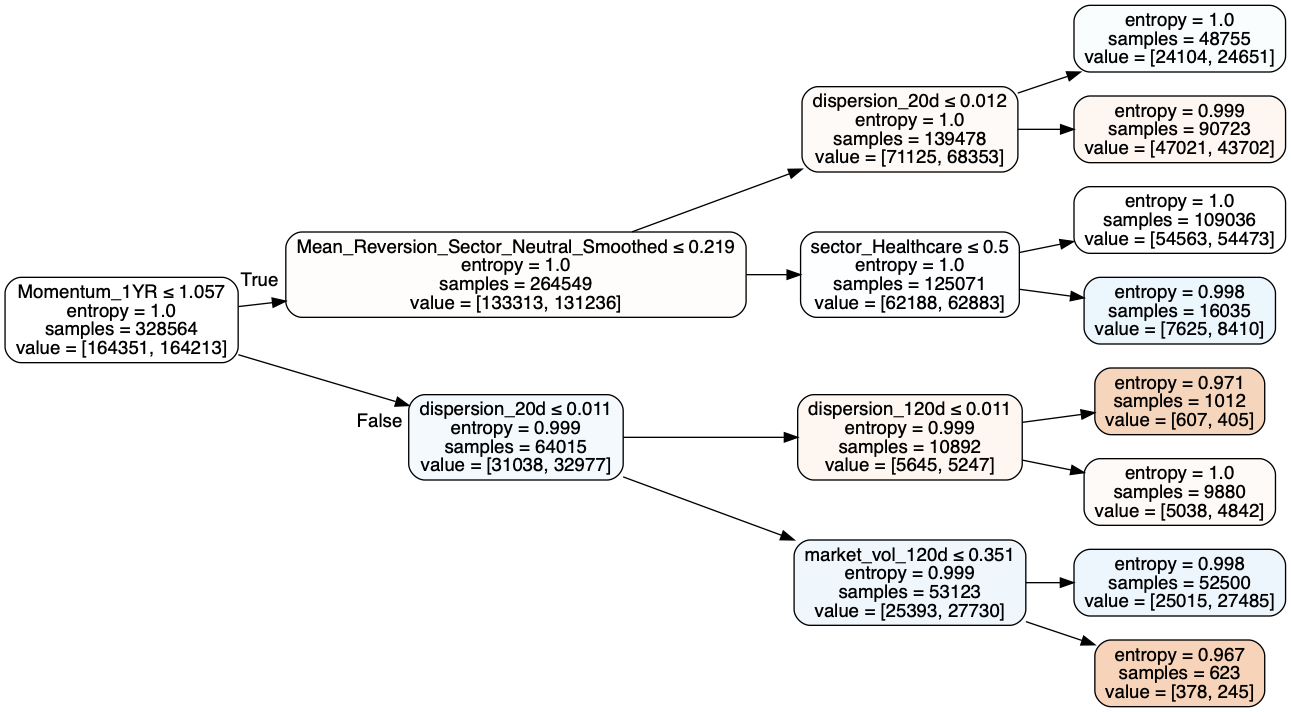

      Feature                                    Importance
 1. dispersion_20d                         (0.3690011658664976)
 2. Momentum_1YR                           (0.21100580926661006)
 3. Mean_Reversion_Sector_Neutral_Smoothed (0.12000764378077436)
 4. market_vol_120d                        (0.11823680390928776)
 5. sector_Healthcare                      (0.09751939990044674)
 6. dispersion_120d                        (0.08422917727638346)
 7. weekday                                (0.0)
 8. Overnight_Sentiment_Smoothed           (0.0)
 9. adv_120d                               (0.0)
10. adv_20d                                (0.0)
11. market_vol_20d                         (0.0)
12. volatility_20d                         (0.0)
13. is_Janaury                             (0.0)
14. is_December                            (0.0)
15. sector_Basic Materials                 (0.0)
16. sector_Energy                          (0.0)
17. month_start                            (0.0)
18. qtr_end 

In [104]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier

# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)
simple_clf.fit(X_train, y_train)

display(helper.plot_tree_classifier(simple_clf, feature_names=features))
helper.rank_features_by_importance(simple_clf.feature_importances_, features)

### Train Random Forests with Different Tree Sizes
#### Parameters
min_samples_leaf parameter to be small enough to allow the tree to fit the data with as much detail as possible, but not so much that it overfits.
Since we have about 500 stocks in the stock universe, we’ll want at least 500 stocks in a leaf for the leaf to make a prediction that is representative. It’s common to multiply this by 2,3,5 or 10, so we’d have min samples leaf of 500, 1000, 1500, 2500, and 5000. 
If sharpe ratio is greater than 4, it would be a sign of “too good to be true”.

In [105]:
n_days = 10
n_stocks = 500

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 150, 250, 350, 500, 750, 1000]

#### Train the model

In [106]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 8/8 [05:09<00:00, 38.69s/Model]


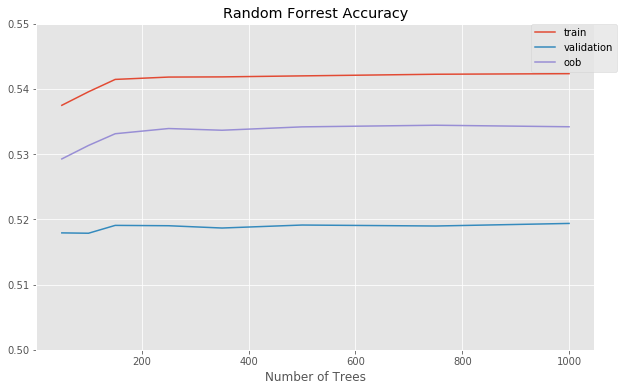

In [107]:
plt.figure(figsize=(10,6))
helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [108]:
print('Features Ranked by Average Importance:\n')
helper.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                    Importance
 1. dispersion_20d                         (0.1352536293903785)
 2. Momentum_1YR                           (0.12553877474116165)
 3. market_vol_120d                        (0.10882081734696405)
 4. market_vol_20d                         (0.09709892547195546)
 5. dispersion_120d                        (0.08871360301877303)
 6. Mean_Reversion_Sector_Neutral_Smoothed (0.08164902932607473)
 7. volatility_20d                         (0.07735245551735634)
 8. Overnight_Sentiment_Smoothed           (0.055289832940890404)
 9. adv_20d                                (0.05432987163539241)
10. adv_120d                               (0.04599530944133484)
11. sector_Utilities                       (0.02651634697702379)
12. sector_Healthcare                      (0.025676602550651937)
13. sector_Consumer Defensive              (0.01810767658293504)
14. sector_Financial Services              (0.01209442

## Model Results
Analyze the followings.
#### Sharpe Ratio
Target Range: 1.5 - 2.0
Below 1.0 is not a good alpha. Above 4.0 is too good to be true.
Information Racio (IC) is the sharpe ratio applied to a specific return.
$
\mbox{IC} = \sqrt{252} * mean(s) / Stdev(s)
$
Market and common factor neutral portofolio will be Sharpe Ratio = IC
Information Ratio (IR) = IC * sqrt(B) where B is breadth, the number of independent bets.

#### Factor Returns
Cumulative factor return should move up and to the right.

#### Basis Points of Factor Returns per Day per Quantile
A good alpha is also monotonic in quantiles. Analyze quintile performance to see Rank IC - if ranked Alpha values are highly correlated with forward future return.
Rank IC = 

#### Turnover Analysis
Factor Rank Autocorrelation to see how stable the alphas are over time before full backtest.

In [109]:
import alphalens as al

all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

def plot_factor_returns(factor_returns, ymin, ymax):
    (1 + factor_returns).cumprod().plot(ylim=(ymin, ymax), figsize=(12,7))
    
def plot_qr_factor_returns(qr_factor_returns):
    (10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)
    
    
def plot_factor_rank_autocorrelation(factor_data):
    ls_FRA = pd.DataFrame()

    unixt_factor_data = {
        factor: factor_data.set_index(pd.MultiIndex.from_tuples(
            [(x.timestamp(), y) for x, y in factor_data.index.values],
            names=['date', 'asset']))
        for factor, factor_data in factor_data.items()}

    for factor, factor_data in unixt_factor_data.items():
        ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

    ls_FRA.plot(title="Factor Rank Autocorrelation", ylim=(0.8, 1.0), figsize=(12,7))
    
def show_sample_results(data, samples, classifier, factors, ymin=0.9, ymax=1.5, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = helper.get_factor_returns(factor_data)
    qr_factor_returns = helper.get_qr_factor_returns(factor_data)
    sharpe_ratio = helper.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    plot_factor_returns(factor_returns, ymin, ymax)
    plot_qr_factor_returns(qr_factor_returns)
    plot_factor_rank_autocorrelation(factor_data)
    
    return factor_data

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [110]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'adv_120d',
    'volatility_20d']

#### Training

Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

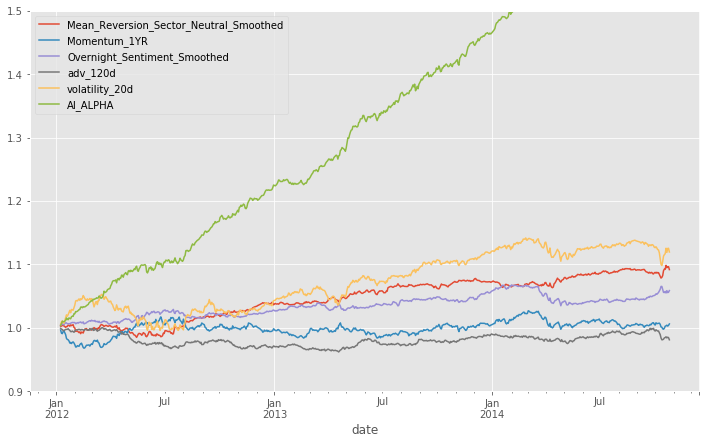

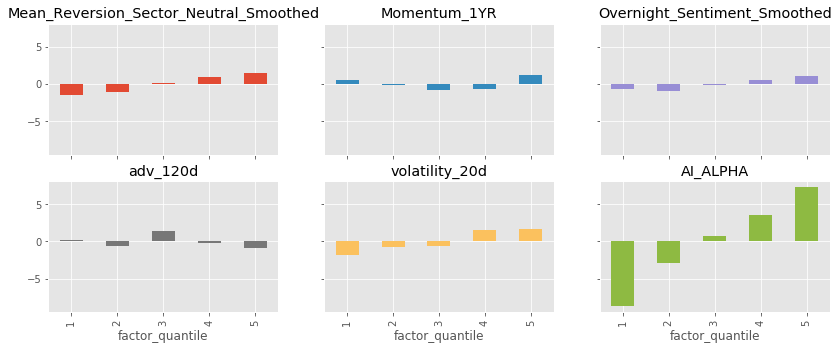

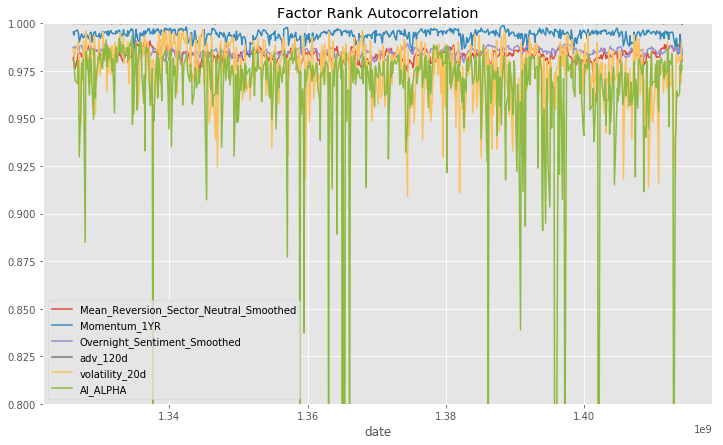

In [111]:
result_factors_train = show_sample_results(all_factors, X_train, clf, factor_names)

In [112]:
result_factors_train['AI_ALPHA']

1D    factor  \
date                      asset                                     
2012-01-09 00:00:00+00:00 Equity(0 [A])        0.006303 -0.000320   
                          Equity(1 [AAL])      0.000000  0.019336   
                          Equity(2 [AAP])      0.000837  0.002933   
                          Equity(3 [AAPL])     0.003583 -0.000872   
                          Equity(5 [ABC])      0.011404  0.006131   
                          Equity(6 [ABT])      0.004635 -0.015025   
                          Equity(7 [ACN])      0.017202  0.000481   
                          Equity(8 [ADBE])     0.023484 -0.002637   
                          Equity(9 [ADI])      0.004357  0.008067   
                          Equity(10 [ADM])    -0.004502  0.005028   
                          Equity(11 [ADP])    -0.000171  0.007922   
                          Equity(12 [ADS])     0.007387  0.035135   
                          Equity(13 [ADSK])    0.046654  0.023420   
                          Equity(14 [AEE])     0.006544 -0.041287   
                          Equity(15 [AEP])     0.006823 -0.038813   
                          Equity(16 [AES])     0.018490 -0.007857   
                          Equity(17 [AET])     0.004071  0.027556   
                          Equity(18 [AFL])     0.014792  0.008423   
                          Equity(19 [AGN])     0.018784  0.014931   
                          Equity(20 [AIG])     0.044581  0.021340   
                          Equity(21 [AIV])     0.009300  0.010012   
                          Equity(22 [AIZ])    -0.007842  0.033572   
                          Equity(23 [AJG])     0.001527  0.006646   
                          Equity(24 [AKAM])    0.016253 -0.004526   
                          Equity(25 [ALB])     0.031073  0.030937   
                          Equity(26 [ALGN])    0.029113  0.035244   
                          Equity(27 [ALK])    -0.011522  0.027285   
                          Equity(28 [ALL])     0.019550  0.004810   
                          Equity(30 [ALXN])    0.005520  0.035447   
                          Equity(31 [AMAT])    0.022941 -0.001634   
...                                                 ...       ...   
2014-10-24 00:00:00+00:00 Equity(190 [FTI])   -0.021822 -0.012443   
                          Equity(191 [GD])     0.004449  0.027740   
                          Equity(192 [GE])    -0.004680 -0.013393   
                          Equity(193 [GGP])    0.009711 -0.003628   
                          Equity(194 [GILD])   0.016981  0.031908   
                          Equity(195 [GIS])    0.002548 -0.035165   
                          Equity(196 [GLW])    0.002673  0.013593   
                          Equity(197 [GM])     0.003982  0.010309   
                          Equity(199 [GOOGL])  0.001785  0.001042   
                          Equity(200 [GPC])    0.000322 -0.022485   
                          Equity(201 [GPN])    0.000128  0.004247   
                          Equity(202 [GPS])    0.015724  0.009759   
                          Equity(203 [GRMN])   0.024428 -0.011195   
                          Equity(204 [GS])     0.003052 -0.000706   
                          Equity(205 [GT])    -0.009605  0.028302   
                          Equity(206 [GWW])    0.002691  0.016982   
                          Equity(207 [HAL])   -0.060769 -0.004296   
                          Equity(208 [HAS])   -0.005113 -0.011007   
                          Equity(209 [HBAN])   0.007305  0.029961   
                          Equity(210 [HBI])    0.001810  0.027307   
                          Equity(211 [HCA])   -0.009291  0.039143   
                          Equity(212 [HCN])    0.008576 -0.031910   
                          Equity(213 [HCP])    0.010732 -0.030785   
                          Equity(214 [HD])     0.005052  0.001245   
                          Equity(215 [HES])   -0.024764 -0.004132   
                          Equity(216 [HIG])    0.00

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

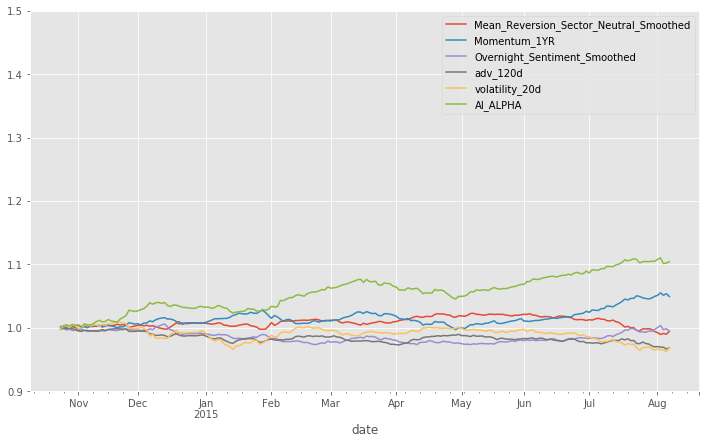

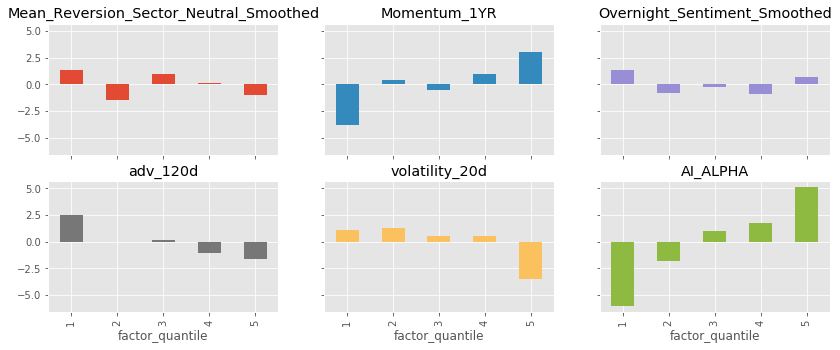

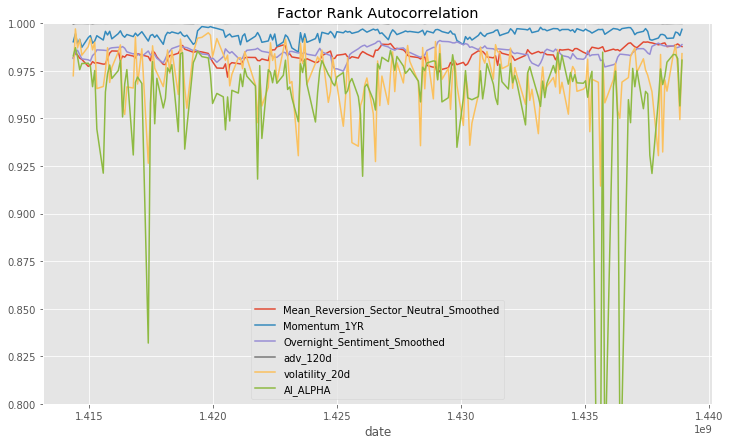

In [113]:
result_factors_valid = show_sample_results(all_factors, X_valid, clf, factor_names)

## Ensemble of non-overlapping trees
To see actual performance in production, correct overlapping samples for the non-IID labels and mitigate likely overfitting.

In [114]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

def calculate_oob_score(classifiers):
    '''
    Calculate the mean out-of-bag score from the classifiers.
    '''
    oob_score = 0
    for clf in classifiers:
        oob_score += clf.oob_score_ 
    return oob_score / len(classifiers)

def non_overlapping_estimators(x, y, classifiers, n_skip_samples):
    '''
    Fit the classifiers to non overlapping data.

    Parameters
    ----------
    x : [DataFrame] The input samples
    y : [Pandas Series] The target values
    '''
    fit_classifiers = []
    
    for i in range(n_skip_samples):
        fit_classifiers.append(
            classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
        )

    return fit_classifiers

class NoOverlapVoter(NoOverlapVoterAbstract):
    def _calculate_oob_score(self, classifiers):
        return calculate_oob_score(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        return non_overlapping_estimators(x, y, classifiers, n_skip_samples)
    

### Train the model

In [115]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models:   0%|          | 0/8 [00:00<?, ?Model/s]/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
Training Models:  12%|█▎        | 1/8 [00:07<00:53,  7.61s/Model]/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not

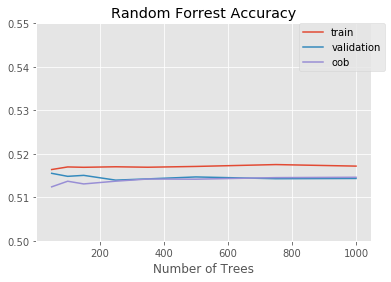

In [116]:
helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

### 

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

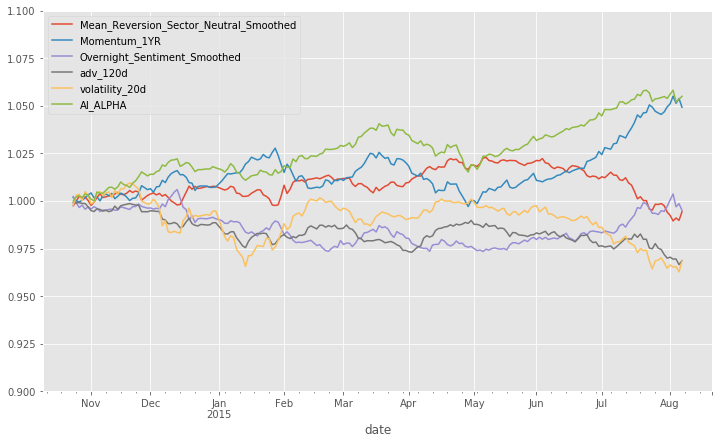

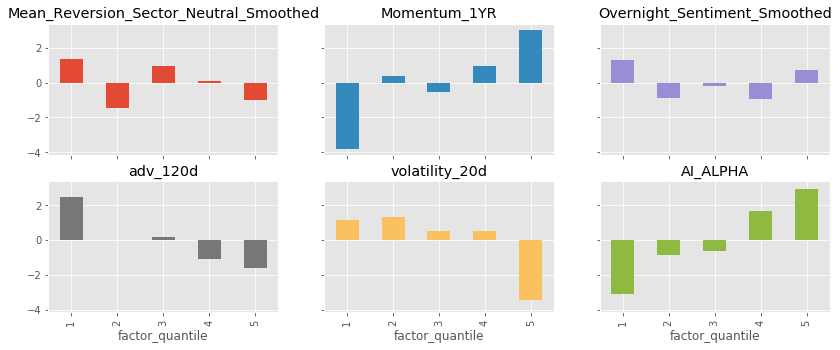

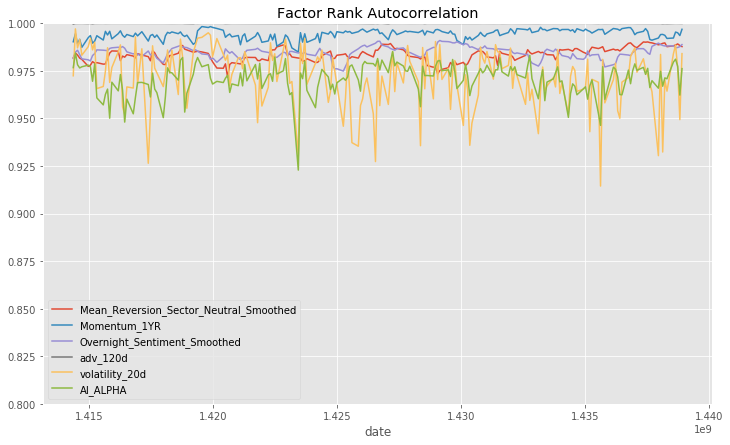

In [117]:
result_factors_valid = show_sample_results(all_factors, X_valid, clf_nov, factor_names, 0.9, 1.1)

## Re-Training
Roll forward the training to "current day" in production, so re-train the model on train & validation dataset here.

In [118]:
n_trees = 350
X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(X_train_valid, y_train_valid)

NoOverlapVoter(estimator=None, n_skip_samples=4, voting='soft')

In [119]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


train: 0.5177225745973387, oob: 0.5317603195739015, valid: 0.5170853092580481


/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

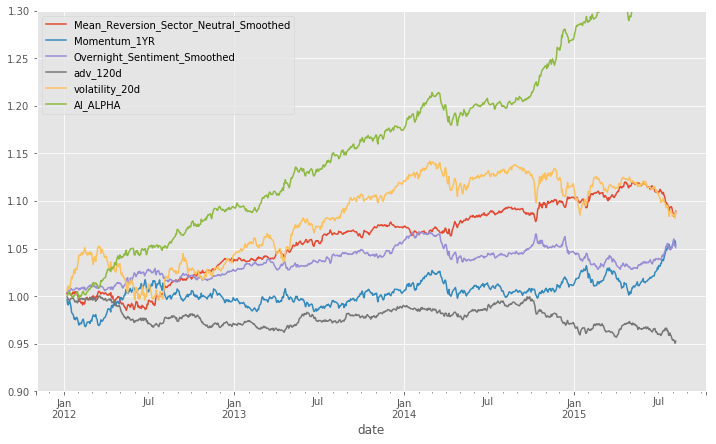

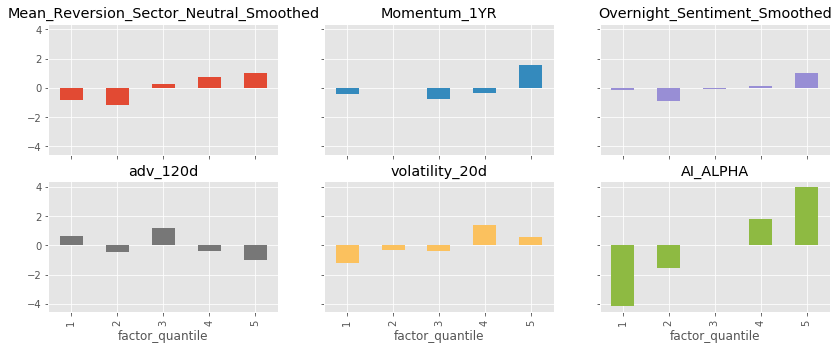

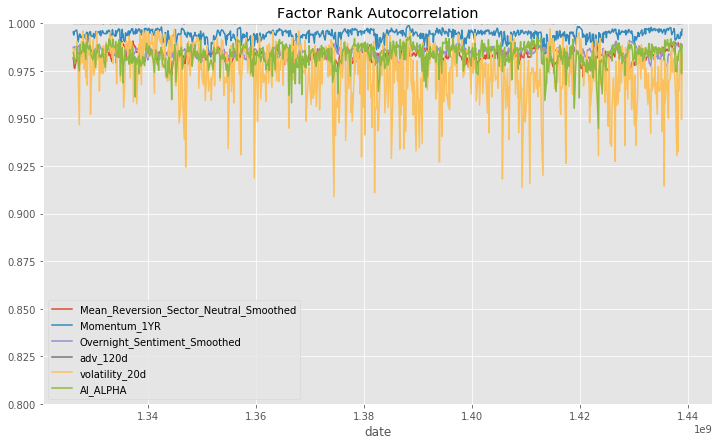

In [120]:
result_factors_retrain = show_sample_results(all_factors, X_train_valid, clf_nov, factor_names, 0.9, 1.3)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

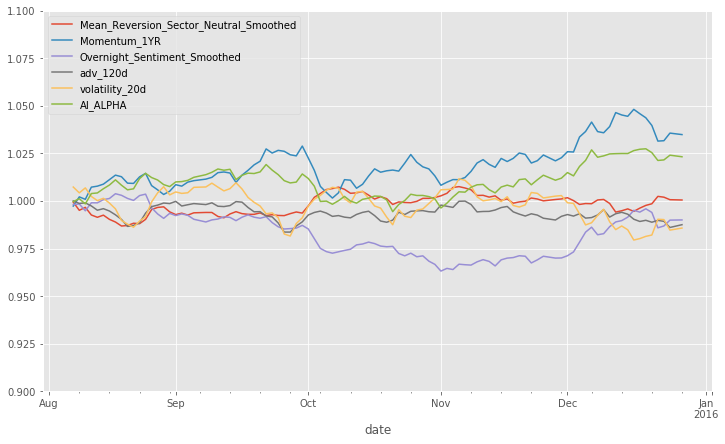

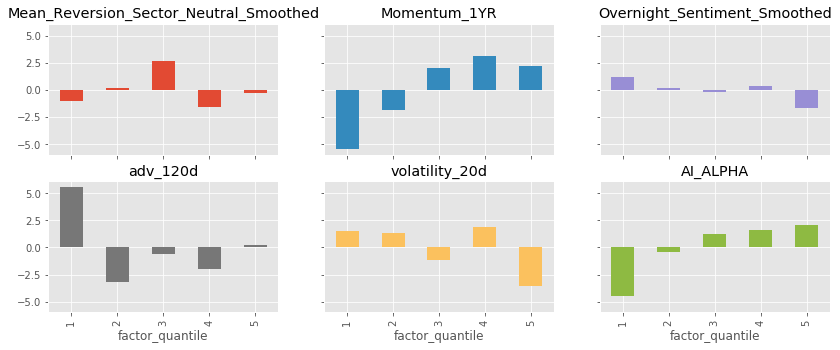

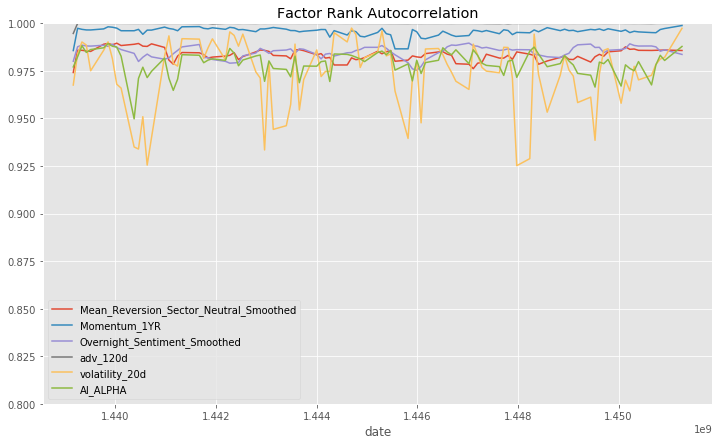

In [121]:
result_factors_test = show_sample_results(all_factors, X_test, clf_nov, factor_names, 0.9, 1.1)

## Alpha Vector

In [137]:
alpha_score = clf_nov.predict_proba(X).dot(np.array([-1,1]))
alpha_score

array([-0.00616815, -0.00765879, -0.00047964, ..., -0.00220749,
        0.01411712, -0.00109512])

In [138]:
alpha_score_label = 'AI_ALPHA'
factors_with_alpha = X.copy()
factors_with_alpha[alpha_score_label] = alpha_score
factors_with_alpha

Mean_Reversion_Sector_Neutral_Smoothed  \
2012-01-06 00:00:00+00:00 Equity(0 [A])                                    -0.055753   
                          Equity(1 [AAL])                                   0.137524   
                          Equity(2 [AAP])                                  -0.167259   
                          Equity(3 [AAPL])                                 -1.706037   
                          Equity(5 [ABC])                                   0.263897   
                          Equity(6 [ABT])                                  -0.412571   
                          Equity(7 [ACN])                                   1.148508   
                          Equity(8 [ADBE])                                 -1.126207   
                          Equity(9 [ADI])                                  -0.784257   
                          Equity(10 [ADM])                                  1.230279   
                          Equity(11 [ADP])                                 -1.386387   
                          Equity(12 [ADS])                                  0.970099   
                          Equity(13 [ADSK])                                 1.624266   
                          Equity(14 [AEE])                                  0.249029   
                          Equity(15 [AEP])                                 -0.323366   
                          Equity(16 [AES])                                  1.178243   
                          Equity(17 [AET])                                 -0.494342   
                          Equity(18 [AFL])                                  0.018584   
                          Equity(19 [AGN])                                  1.594531   
                          Equity(20 [AIG])                                  0.122656   
                          Equity(21 [AIV])                                 -0.130090   
                          Equity(22 [AIZ])                                 -0.903196   
                          Equity(23 [AJG])                                 -1.044436   
                          Equity(24 [AKAM])                                -1.230279   
                          Equity(25 [ALB])                                  0.717353   
                          Equity(26 [ALGN])                                 1.051870   
                          Equity(27 [ALK])                                  0.509209   
                          Equity(28 [ALL])                                 -0.092921   
                          Equity(30 [ALXN])                                -0.888329   
                          Equity(31 [AMAT])                                -0.308499   
...                                                                              ...   
2015-12-28 00:00:00+00:00 Equity(459 [VRSK])                               -1.585935   
                          Equity(460 [VRSN])                                0.901666   
                          Equity(461 [VRTX])                                1.514657   
                          Equity(462 [VTR])                                -1.037094   
                          Equity(463 [VZ])                                 -0.024947   
                          Equity(464 [WAT])                                 0.367082   
                          Equity(465 [WBA])                                -0.744855   
                          Equity(466 [WDC])                                -0.074842   
                          Equity(467 [WEC])                                -0.523893   
                          Equity(468 [WFC])                                -0.609427   
                          Equity(469 [WHR])                                 1.265184   
                          Equity(471 [WM])                                 -0.630810   
                          Equity(472 [WMB])                                 1.657213   
                          Equity(473 [WMT])                                 0.103353  

In [141]:
# Take the last day's alpha as Alpha Vector
print(factors_with_alpha.index.get_level_values(0)[-1])
alphas = factors_with_alpha[[alpha_score_label]]
alpha_vector = alphas.loc[factors_with_alpha.index.get_level_values(0)[-1]]
alpha_vector.head()

2015-12-28 00:00:00+00:00


,AI_ALPHA
Equity(0 [A]),0.009833
Equity(1 [AAL]),-0.022447
Equity(2 [AAP]),-0.001552
Equity(3 [AAPL]),-0.006319
Equity(4 [ABBV]),0.002303


## Optimal Portfolio Constrained by Risk Model
AI_ALPHA looks promising, so find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.

In [142]:
from abc import ABC, abstractmethod

class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints

### Objective Function
Maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

### Constraints
The first constraint is that the predicted risk be less than some maximum limit. 
- $ r \leq risk_{\text{cap}}^2 \\ $

The second and third constraints are on the maximum and minimum portfolio factor exposures. 
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $

The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. 
- $ x^T\mathbb{1} = 0 \\ $

The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. 
- $ \|x\|_1 \leq 1 \\ $

The last are some minimum and maximum limits on individual holdings.
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk



In [143]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        assert(len(alpha_vector.columns) == 1)
        objective = cvx.Minimize(-alpha_vector.values.flatten()*weights)
        
        return objective
    
    def _get_constraints(self, weights, factor_betas, risk):

        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        constraints = [
        risk <= self.risk_cap ** 2,   
        factor_betas.T*weights <= self.factor_max,
        factor_betas.T*weights >= self.factor_min,
        sum(weights) == 0.0,
        sum(cvx.abs(weights)) <= 1.0,
        weights >= self.weights_min,
        weights <= self.weights_max        
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

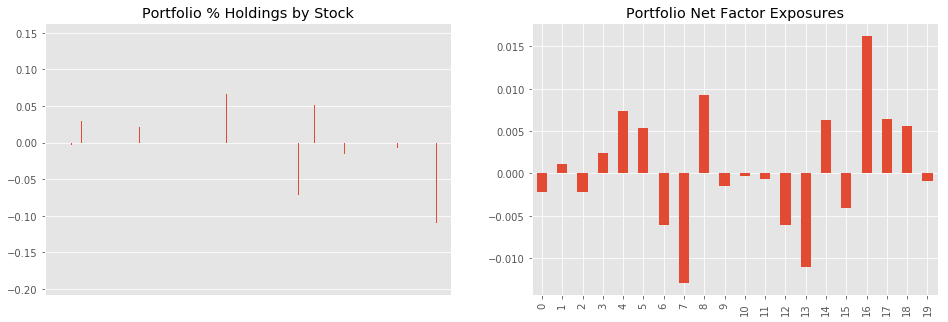

In [144]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock', ax=ax1)
ax1.axes.xaxis.set_visible(False)
helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False, ax=ax2)

## Optimize with a Regularization Parameter
In order to enforce diversification, use regularization in the objective function. 

Maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

In [145]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        objective = cvx.Minimize(-alpha_vector.values.flatten()*weights + self.lambda_reg*cvx.norm(weights,2))
        
        return objective

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

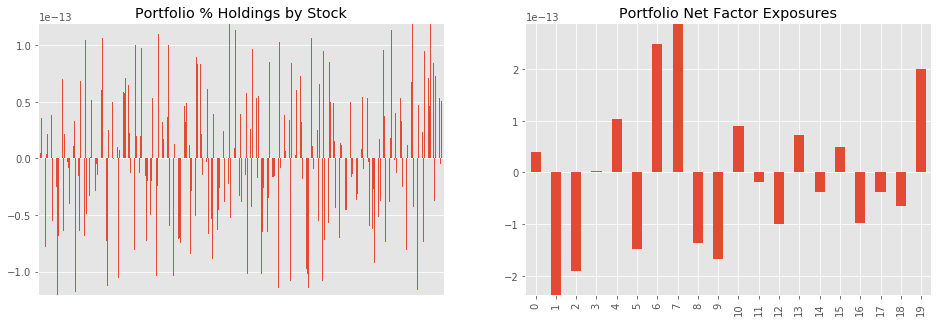

In [146]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock', ax=ax1)
ax1.axes.xaxis.set_visible(False)
helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures', legend=False, ax=ax2)

## Optimize for Target Weight
Minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting, while respecting portfolio-level constraints. 

In [147]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        objective = cvx.Minimize(cvx.norm(alpha_vector.values.flatten()-weights,2))
        
        return objective


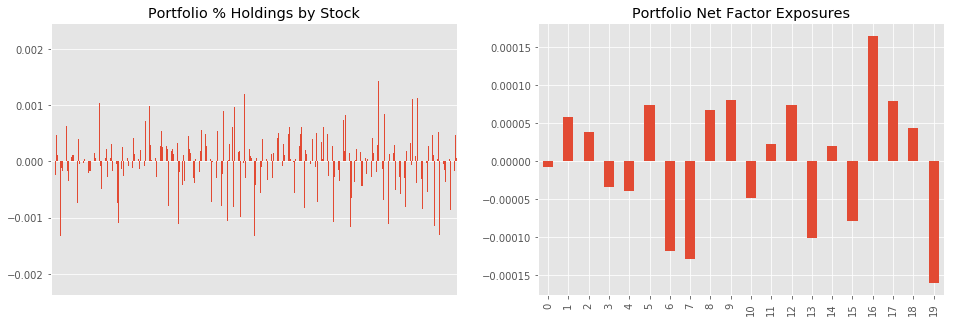

In [148]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock', ax=ax1)
ax1.axes.xaxis.set_visible(False)

helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures', legend=False, ax=ax2)

In [149]:
optimal_weights_2

,0
Equity(0 [A]),0.000567
Equity(1 [AAL]),-0.000323
Equity(2 [AAP]),-0.000005
Equity(3 [AAPL]),-0.000066
Equity(4 [ABBV]),0.000136
Equity(5 [ABC]),-0.000237
Equity(6 [ABT]),0.000476
Equity(7 [ACN]),0.000111
Equity(8 [ADBE]),0.000205
Equity(9 [ADI]),0.000107


### Transfer Coefficient
Correlation between Alpha vector and final portfolio weight

$$
corr(\alpha, x)
$$


In [165]:
np.corrcoef(alpha_vector[alpha_score_label].values.tolist(), optimal_weights_2[0].values.tolist())

array([[1.        , 0.78027715],
       [0.78027715, 1.        ]])

The correlation is around 78%.
It's worth trying to see the return in full backtest.


## Prepration for backtest

In the backtest, the followings will be need to be additionally considered:
 - 2 days delay between factor date and return date to allow trading
 - Remove look ahead bias by selecting universe on each day and use only the data available to each day
 - Transaction Cost
 - Continuously training the estimator using the latest data available for each day.

This means, the data available for back test would be around 2 years, 2014 and 2015 because
 - Original data: 5 years from Jan 2011 to Jan 2016
 - Factor data: 4 years from Jan 2012 to Jan 2016
 - Weekly return: The last week cannot be used, so from Jan 2012 to Dec 2015
 - Keep rolling window of 2 years for training AI Alpha, resulting in the range from Jan 2014 to Dec 2015

In addition, covariance matrix should be calculated on each day as the universe changes on daily basis.